In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

In this notebook we run the distributional DMD and the SKO algorithm on data coming from an SDE
$$ dX_t = a(X_t, t) dt + b(X_t, t) dW_t$$ 

If $b(x, t) = e^{-\frac{1}{2}V(x)}$, then the equation has a steady state solution of this SDE:
$$\rho \sim e^{-V(x)}$$
When implementing we will ignore the $t$ dependence in $a$ and $b$.

In [2]:
def euler_maruyama(x0, a, b, T, N):
    """
    implements the euler maruyama method with initial condition x0 and
    coefficients a and b, for time T. The interval [0, T] is partitioned
    in N steps. We impose BC to keep the data within [-2, 2]
    """
    dt = T/N
    y = np.zeros(N + 1)
    y[0] = x0
    for i in range(N):
        y[i + 1] = ( y[i] + np.random.normal()* np.sqrt(dt)*b(y[i]) + a(y[i])* dt )% 4 - 2 
    return y



### SKO on a long trajectory
We compute the $K_{SKO}$ matrix using a long trajectory, then we test its prediction for $\Delta t$ into the future. To test the prediction we generate K = 100 trajectories starting from $x = 0$ and compute the expectation of $h(X_t)$ along these trajectories. We then compare that to $K_{SKO} h(x)$ . Throughout we will use $\Delta t = 0.1$   
Select radial basis functions $$h_i = \phi_{c_i} = e^{-\epsilon (x - c)^2}$$
Here we select $c_i \in \{-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2\}$ and $\epsilon = 0.5$. 

Next we generate the data matrices $E_{ij} = h_i(x_j)$ and $D_{ij} = h_i(x_{j + 1})$
Finally, we compute the SKO Koopman matrix using the formula $K = DE^\dagger$. This is a summary of the function algorithm

### DKO on an ensemble of trajectories
First generate K = 1000 trajectories, each with initial condition sampled from $\mathcal{N}(0,\frac{1}{\sqrt{2}}) $
Next we generate data matrices E, D where now:
$$E_{ij} = h_i(\pi_j) = \frac{1}{K} \sum_{k = 1}^K \phi_{c_i} (data[k, j])$$ and 
$$D_{ij} = h_i(\pi_{j + 1}) = \frac{1}{K} \sum_{k = 1}^K \phi_{c_i} (data[k, j + 1])$$ 

There are three options one can choose from for the data of the DKO algorith. They can be specified by changing the variable distr that is an argument of the DKO function
- distr = "mixing" : in this scenario the DKO data is one long trajectory of the system, assuming that the system is mixing. The measures are conditional distributions on subsets of the range
- distr = "trajectory": in this scenario the data consists of a trajectory $\pi_t$ of the density, each represented by an empirical distribution.
- distr = "normal"/"uniform"/"delta": here the data is sampled from a norma, uniform or a delta distribution centered at equidistant points in the domain and run forward for one time step.

In [72]:
def SKO(a, b, x0 = 0):
    r"""
        Implemetns the SKO algorithm, given a and  b 
        The number of steps in each simulation is N fixed, Dt is also fixed, the time for sko is T_KSO 
        The radial basis functions will be used throughout
    """
        # set hyperparameters
    T_SKO = 210
    N = 21000
 
    eps = 0.5
    # compute the trajectory for SKO
    Xt = euler_maruyama(x0, a, b, T_SKO, N)

    # the SKO data will be the trajectory data with a step of Dt in between 
    current_step = T_SKO/N
    Xt = Xt[:: int(Dt/current_step)]
    N_SKO = np.size(Xt)
    print("Number of data points for SKO:", N_SKO)
    E_SKO = np.zeros((9, N_SKO -1))
    D_SKO = np.zeros((9, N_SKO -1))
    for i in range(9):
        c = -2 + i*0.5
        phi_c_Xt = np.exp(-eps* (Xt - c)**2)
        E_SKO[i, :] = phi_c_Xt[:-1]
        D_SKO[i, :] = phi_c_Xt[1:]
    K_SKO = D_SKO@np.linalg.pinv(E_SKO, rcond = 1e-5)
    return K_SKO
    
def DKO(a, b, distr = "trajectory", x0 = 0):
    r"""
        Implemetns the DKO algorithm, given a and  b 
        The number of steps in each simulation is N fixed, Dt is also fixed, the time for DKO is T_DKO
        K = number of samples in each measure
        The radial basis functions will be used throughout

        For the measures there are two options:
        - use trajectory i.e. we have a long \pi_t trajectory each consisting of K samples and we chose \mu_j = \pi_{j + 1}
        - use normal distributions centered at equidistant points between -2 and 2 with standard deviation 1
        - use dirac deltas at different locations as a starting point
        - assuming the data comes from one long mixing trajectory we construct measures to be conditional distributions
    """
    # set hyperparameters
    T_SKO = 210
    N = 21000
    eps = 0.5
 

    # for the time step in the computation of the trajectory choose the same precision as SKO
    current_step = T_SKO/N
    
    if distr == "trajectory":
        # number of samples 
        K = 100
    
        # number of measures = number of time steps on the trajectory since \mu_j = \pi_{j + 1}
        m = 20

        # time that DKO observes
        T_DKO = Dt*m

        # how many data points for simulating euler maruyama
        N_DKO = int(T_DKO/current_step)
        
        data = np.zeros((K, N_DKO + 1))
        for j in range(K):
            # uncomment this if you want the initial distribution to be a delta at 0
            # x0 = 0

            # uncomment this if you want the initial distribution to be normal
            x_0 = np.random.normal(loc = 0, scale = 1/np.sqrt(2))
            data[j, :] = euler_maruyama(x_0, a, b, T_DKO, N_DKO)
            
        # DKO data is the trajectory data but with a step of Dt in between instead of current_step
        data = data[:, ::int(Dt/current_step)]
        
        # update the number of points in the data
        (_, N_DKO) = np.shape(data)
        print("Number of points for DKO:", np.size(data))
        # Compute the E and D matrices
        E_DKO = np.zeros((9, N_DKO - 1))
        D_DKO = np.zeros((9, N_DKO - 1))
        for i in range(9):
            c = -2 + i*0.5
            phi_c_data = np.zeros((N_DKO, ))
            for k in range(K):
                phi_c_data += 1/K*np.exp(-eps* (data[k, :] - c)**2)
            E_DKO[i, :] = phi_c_data[:-1]
            D_DKO[i, :] = phi_c_data[1:]

        #  uncomment to plot the ensemble of trajectories
        #for j in range(K):
        #    plt.plot(np.linspace(0, T_DKO, N_DKO), data[j, :])
        #plt.title("DKO data")
        #plt.grid()
        #plt.show()
        
    elif distr =="mixing":
        # length of trajectory
        N = 10000

        # number of boxes = number of measures
        m = 20

        # generate trajectory
        Xt = euler_maruyama(x0, a, b, T_SKO, N)

        # see which data points falls in which box
        indices = np.digitize(Xt, np.linspace(np.min(Xt), np.max(Xt), 20), right = True)

        # sort the boxes and the data points accordingly
        order = np.argsort(indices)
        Xt = Xt[order]
        indices = indices[order]

        # compute the E and D matrices
        E_DKO = np.zeros((9, m))
        D_DKO = np.zeros((9, m))
        for i in range(9):
            c = -2 + i*0.5

            # index that keeps track of bin number
            j = 0

            # index that keeps track of which data point we are considering
            k = 0
            while  j < m:
                counts = 0
                while k <= N and indices[k] == j:
                    counts = counts + 1                   
                    E_DKO[i, j] = E_DKO[i, j] + np.exp(-eps* (Xt[k] - c)**2)
                    if k < N:
                        D_DKO[i, j] = D_DKO[i, j] + np.exp(-eps* (Xt[k + 1] - c)**2)
                    k = k + 1
                    
                E_DKO[i, j] = E_DKO[i, j]/counts
                D_DKO[i, j] = D_DKO[i, j]/counts
                j = j + 1
        
    else:
        # compute for one Dt time step the trajectory from different measures
        T_DKO = Dt
        N_DKO = int(N*T_DKO/T_SKO)
        # number of samples and number of different measures
        K = 1000
        m = 10
        E_DKO = np.zeros((9, m))
        D_DKO = np.zeros((9, m))
        data0 = np.zeros((m, K))
        data1 = np.zeros((m, K))
        for j in range(m):
            for k in range(K):
                # generate initial condition
                if distr == "normal":
                    x_0 = np.random.normal()*0.4 - 2 + 0.4*j

                if distr == "uniform":
                    x_0 = -2 + 4/m*j +  4 / m * np.random.uniform()
                if distr == "delta":
                    x_0 = x0
                    
                data0[j, k] = x_0
                trajx0 = euler_maruyama(x_0, a, b, T_DKO, N_DKO)
                data1[j, k] = trajx0[-1]

               
  
        for i in range(9):
            c = -2 + i*0.5
            phi_c_data0 = np.zeros((m, ))
            phi_c_data1 = np.zeros((m, ))

            for k in range(K):
                phi_c_data0 += 1/K*np.exp(-eps* (data0[:, k] - c)**2)
                phi_c_data1 += 1/K*np.exp(-eps* (data1[:, k] - c)**2)
            E_DKO[i, :] = phi_c_data0
            D_DKO[i, :] = phi_c_data1
    K_DKO = D_DKO@np.linalg.pinv(E_DKO, rcond = 1e-5)
   
    return  K_DKO

def plot_eigens(K_SKO, K_DKO):
    # parameters
    eps= 0.5
     # Plot the eigenvalues and compare
    evals_SKO, evects_SKO = np.linalg.eig(K_SKO)
    plt.plot(np.real(evals_SKO), np.imag(evals_SKO), '.', label = 'SKO')
    plt.title("Eigenvalues")
    plt.grid()
    evals_DKO, evects_DKO = np.linalg.eig(K_DKO)
    plt.plot(np.real(evals_DKO), np.imag(evals_DKO), 'x', label = 'DKO')
    plt.legend()
    plt.show()

    # plot the dominant eigenfunctions and compare
    max_eval_SKO = np.argmax(evals_SKO)
    max_evect_SKO = evects_SKO[:, max_eval_SKO]
    max_eval_DKO = np.argmax(evals_DKO)
    max_evect_DKO = evects_DKO[:, max_eval_DKO]
    x = np.linspace(-2, 2, 100)
    eigf_SKO = np.zeros((100, ))
    eigf_DKO = np.zeros((100, ))
    for i in range(9):
        c = -2 + i*0.5
        eigf_SKO  = eigf_SKO + np.exp(-eps* (x - c)**2)*max_evect_SKO[i]
        eigf_DKO  = eigf_DKO + np.exp(-eps* (x - c)**2)*max_evect_DKO[i]

    plt.plot(x, np.real(eigf_SKO),'b',  label = "SKO")
    plt.plot(x, np.real(eigf_DKO), 'g', label = "DKO")
    plt.plot(x, np.imag(eigf_SKO), 'b')
    plt.plot(x, np.imag(eigf_DKO), 'g')
    plt.grid()
    plt.legend()
    plt.title("Dominant eigenfunction")
    plt.show()

In order to compute and predict variance we ned to consider the Koopman operator restricted to a different space of observables $H_1 \cup H_2$. We will choose basis functions to be $$\left\{\int \hat{h}_i d\pi \int \hat{h}_j d\pi, \int \hat{h}_i\hat{h}_j d\pi\right\}_{i = 1, j = i}^n$$ This is an $n(n + 1)$ dimensional space. We compute matrices E and D in the same fashion as before but for this different library.

In [22]:
def var_DKO(a, b, distr = "trajectory"):
    # number of samples 
    K = 100

    n = 9
    # number of measures = number of time steps on the trajectory since \mu_j = \pi_{j + 1}
    m = 100
    N_DKO = int(m*Dt/current_step)      
    T_DKO = Dt*m
    data = np.zeros((K, N_DKO + 1))
    for j in range(K):
        # uncomment this if you want the initial distribution to be a delta at 0
        # x0 = 0

        # uncomment this if you want the initial distribution to be normal
        x_0 = np.random.normal(loc = 0, scale = 1/np.sqrt(2))
        data[j, :] = euler_maruyama(x_0, a, b, T_DKO, N_DKO)
    # DKO data is the trajectory data but with a step of Dt in between
    data = data[:, ::int(Dt/current_step)]

    # update the number of points in the data
    (_, N_DKO) = np.shape(data)

    # compute the E and D matrices 
    pass

# Predictions
 In order to find the expectation we generate 100 paths starting from $x_0$ and average them. We do this for $100$ different initial conditions between [-2, 2] and store each expectation in the rows of the matrix expectations. We compare this to the prediction of the SKO vs DKo algorithms given by $K_{N\Delta t} h_i(\delta_{x_j}) = \textbf{K}^N_{\Delta t} H$, where $H = h_i(\delta_{x_j})$

In [23]:
def prediction(K, a, b):
    """
        Given the formula for the SDE, and the matrix approximation K, it computes the predicted value of the radial basis functions 
        under the SDE for time T by repeatedly multiplying with K.
    """
    # hyperparameters: number of grid points for function evaluation
    N_x0 = 101
    x0 = np.linspace(-2, 2, N_x0)

    # number of dictionary functions
    n = 9

    # parameters of radial basis functions
    eps = 0.5
    
    # time duration and number of time steps
    T = 11
    N = int((T ) /(Dt))


    # compute the prediction for the expectation using the Koopman operator

    # array to hold the results dimension 3 represents the time of the prediction, dim 2 is the evaluation point $\delta_x_j$ and 
    # dim 1 is the observable
    
    predictions = np.zeros((n, N_x0, N + 1))

    # matrix H_ij = h_i(\delta_x_j)         
    H = np.zeros((n, N_x0))
    for i in range(n):
        c = -2 + i*0.5
        for xx in range(N_x0):
            H[i, xx] = np.exp(-eps* ( x0[xx]- c)**2)

    predictions[:, :, 0] = H
    for j in range(1, N + 1):
        predictions[:, :, j] = K @ predictions[:, :, j -1] 
    return  predictions

def expectations(a, b, variance = 0):
    """
        Given the formula for the SDE, it computes the expected value of the radial basis functions 
        under the SDE for time T = 10
    """

    # parameters

    # time duration 
    T = 11

    # distance between two consecutive time steps
    #Dt = 1

    # how many grid points we approximate the function on
    N_x0 = 101

    # number of observables
    n = 9
    # parameters of radial basis functions
    eps = 0.5

    # number of trajectories to compute expectation over
    N_sample = 100

    # compute the expectation for N time steps
    N = int((T) /(Dt))

    x0 = np.linspace(-2, 2, N_x0)

    # array to hold for each observable, and each grid point, for each time, the position of each trajectory
    data_predictions = np.zeros((n, N_x0, N + 1, N_sample))
    for i in range(n):
        c = -2 + i*0.5
        for xx in range(N_x0):
            for repeat in range( N_sample):
                    data_predictions[i, xx, :, repeat] = np.exp(-eps* ( euler_maruyama(x0[xx], a, b, T , N)- c)**2)
    expectations = 1/N_sample * np.sum(data_predictions, axis = 3)
    if variance == 0:
        return expectations
    else:
        # for each initial position x and each time it computes E[h_a(x_t)h_b(x_t)|x_0 = x] 
        covariances = np.zeros((n, n,  N_x0, N + 1, N_sample))
        for i in range(n):
            ci = -2 + i*0.5
            for j in range(n):
                cj = -2 + i*0.5
                for xx in range(N_x0):
                    for repeat in range(N_sample):
                        covariances[i, j, xx, :, repeat] =np.exp(-eps* ( data_predictions[i, xx, :, repeat] 
                                                                        - ci)**2) *np.exp(-eps* ( data_predictions[j, xx, :, repeat] 
                                                                        - cj)**2)
        covariances = 1/N_sample * np.sum(covariances, axis = 4)
        return expectations, covariances
    

Using the same algorithm we compute the DKO and SKO matrix approximations for the below cases, and plot as before the eigenvalues, and dominant  eigenfunction
# I. State independent noise, ergodic trajectory
$$dX_t = - \sin{x} dt + dB_t$$

SKO and DKO need to see the same time intervals. 

In [78]:
def a(x):
    return -np.sin(2*np.pi*x)
def b(x):
    return 1 
    
Dt = 0.1
K_DKO = DKO(a, b, distr = "trajectory")

Number of points for DKO: 2100


In [74]:
K_SKO = SKO(a, b)


Number of data points for SKO: 2101


In [75]:
truth = expectations(a, b)

for plotting purposes look at the prediction of each basis function $h_i$, compute the error in prediction and find the average over all errors. We compute 
$$ MSE_t = \frac{1}{n} \| \hat{h}_i(x_t)^{true} -\hat{h}_i(x_t)^{pred}\|_{L^2}$$

In [79]:
pred_SKO = prediction(K_SKO, a, b)
pred_DKO = prediction(K_DKO, a, b)

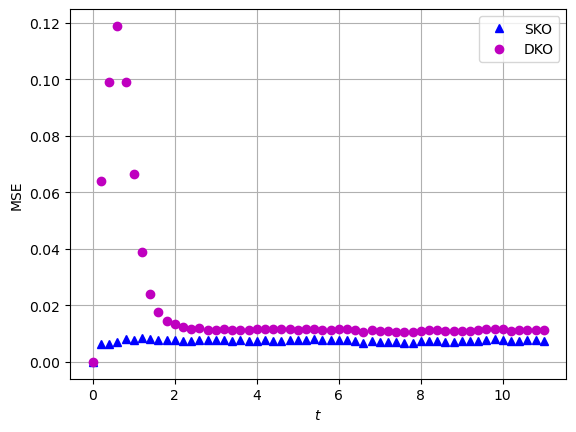

In [80]:
n, N_x0, N = np.shape(truth)
dx = 4/N_x0


mean_square_error_SKO = 1/n* np.sum( integrate.trapezoid((pred_SKO-truth)**2, dx = dx, axis = 1), axis = 0 )
mean_square_error_DKO = 1/n* np.sum( integrate.trapezoid((pred_DKO-truth)**2, dx = dx, axis = 1), axis = 0 )
#error_basis_SKO = 1/n* np.sum((pred_SKO - truth)**2 , axis = 0)
#error_basis_DKO = 1/n* np.sum((pred_DKO -truth)**2 , axis = 0)


time = np.linspace(0, 11, N )
# try trapezoidal rule instead
plt.plot(time[::2], mean_square_error_SKO[::2], 'b^',label = "SKO")
plt.plot(time[::2], mean_square_error_DKO[::2], 'mo', label = "DKO")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("MSE")
plt.grid()
#plt.ylim(0,1)
#plt.xlim(0, 2)
plt.show()
#plot_eigens(K_SKO, K_DKO)

In [25]:
N_exp = 50
n, N_x0, N = np.shape(truth)

# array to hold the results
results_SKO = np.zeros((N_exp, N))
results_DKO = np.zeros((N_exp, N))

for repeat in range(N_exp):
    K_SKO = SKO(a, b)
    K_DKO = DKO(a, b, distr = "trajectory")
    pred_SKO = prediction(K_SKO, a, b)
    pred_DKO = prediction(K_DKO, a, b)
    # uncomment if you want to compute the error or the average function
    # g_pred_SKO = 1/n* np.sum(pred_SKO, axis = 0)
    # g_pred_DKO = 1/n* np.sum(pred_DKO, axis = 0)
    # mean_square_error_SKO = np.sqrt(np.trapezoid((g_true - g_pred_SKO)**2, axis = 0))
    # mean_square_error_DKO = np.sqrt(np.trapezoid((g_true - g_pred_DKO)**2, axis = 0))
    if np.max(pred_SKO) > 10**4:
        print("caca", pred_SKO, pred_DKO)
    mean_square_error_SKO = 1/n* np.sum( integrate.trapezoid((pred_SKO-truth)**2, dx = dx, axis = 1), axis = 0 )
    mean_square_error_DKO = 1/n* np.sum( integrate.trapezoid((pred_DKO-truth)**2, dx = dx, axis = 1), axis = 0 )

    results_SKO[repeat, :] = mean_square_error_SKO
    results_DKO[repeat, :] = mean_square_error_DKO


In [30]:
mean_SKO = np.mean(results_SKO, axis = 0)
mean_DKO = np.mean(results_DKO, axis = 0)
var_SKO = np.std(results_SKO, axis = 0)/np.sqrt(N_exp)
var_DKO = np.std(results_DKO, axis = 0)/np.sqrt(N_exp)

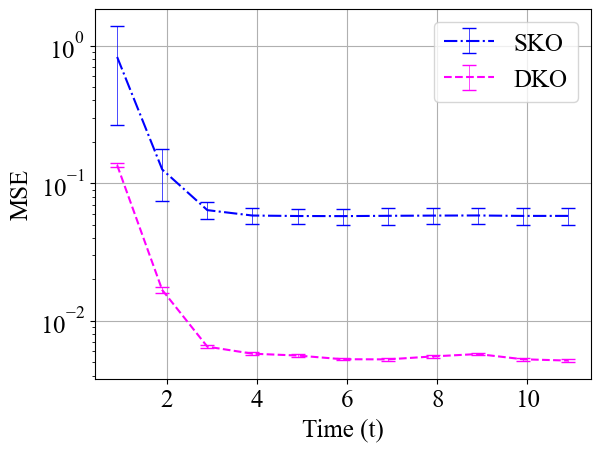

In [31]:
#plot the results
plt.figure()
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})

plt.errorbar(time[9::10], mean_SKO[9::10], yerr = var_SKO[9::10],
             linestyle = "-.", color = "blue", capsize = 5, label = "SKO", elinewidth = 0.5 )
plt.errorbar(time[9::10], mean_DKO[9::10], yerr = var_DKO[9::10], 
             linestyle = "--", color = "magenta", capsize = 5, label = "DKO", elinewidth = 0.5)
plt.xlabel("Time (t)")
plt.ylabel("MSE")
plt.legend()
plt.yscale("log")
plt.grid()
plt.savefig("state_dependent.png")

In the following we compute the variance along the trajectory and compare it to the SKO prediction of the variance

# II. State dependent noise, ergodic trajectory

The equations of motion are 
$$ dX_t =  - \frac{\pi}{2} \sin {0.5\pi x} + \frac{\pi}{4} \sin(\pi x)dt + \sqrt{ 1 + \sin^2(0.5 \pi x)}dB_t$$


In [32]:
def a(x):
    #return -np.sin(x)
    # return (x + 2)/4*( 2 - (x + 2)**2/4**2)
    return - (np.pi / 2) * np.sin(np.pi * x / 2) + (np.pi / 4) * np.sin(np.pi * x)
def b(x):
    #return  0.2*np.exp(-0.5*(x-1)**2)
    #return 0.5*(1 - (x + 2)**2/4**2)
    return np.sqrt(1 + np.sin(np.pi * x / 2)**2)
K_SKO = SKO(a, b)


In [33]:
K_DKO = DKO(a, b, distr = "trajectory")

In [34]:
truth_dependent = expectations(a, b)

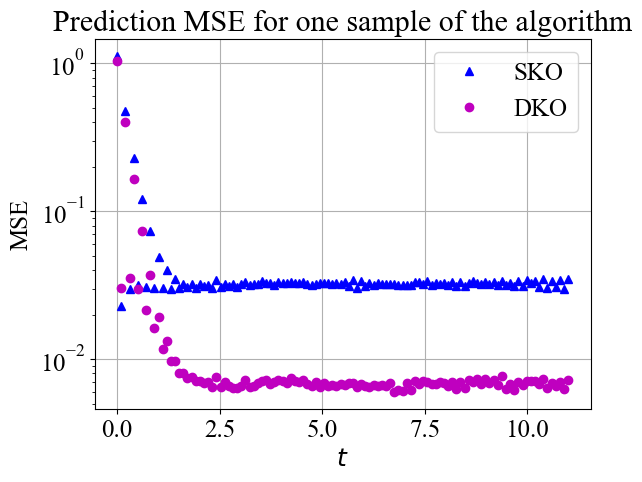

In [35]:
n, N_x0, N = np.shape(truth_dependent)
dx = 4/N_x0

pred_SKO = prediction(K_SKO, a, b)
pred_DKO = prediction(K_DKO, a, b)

mean_square_error_SKO = 1/n* np.sum( np.trapezoid((pred_SKO-truth_dependent)**2, axis = 1)*dx, axis = 0 )
mean_square_error_DKO = 1/n* np.sum( np.trapezoid((pred_DKO-truth_dependent)**2, axis = 1)*dx, axis = 0 )


plt.semilogy(np.linspace(0, 11, N- 1 ), mean_square_error_SKO[1:], 'b^',label = "SKO")
plt.semilogy(np.linspace(0, 11, N - 1), mean_square_error_DKO[1:], 'mo', label = "DKO")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("MSE")
plt.grid()
#plt.ylim(0,1)
#plt.xlim(0, 2.5)
plt.title("Prediction MSE for one sample of the algorithm")
plt.show()


In the following we repeat the experiments N_exp = 100 times to obtain the mean and standard deviation of the DKO vs SKO prediction. We plot them together with their errorbars. 

In [37]:
N_exp = 50
# array to hold the results
results_SKO = np.zeros((N_exp, N))
results_DKO = np.zeros((N_exp, N))


g_true = 1/n*np.sum(truth_dependent, axis = 0)

for repeat in range(N_exp):
    K_SKO = SKO(a, b)
    K_DKO = DKO(a, b, distr = "trajectory")
    pred_SKO = prediction(K_SKO, a, b)
    pred_DKO = prediction(K_DKO, a, b)

    mean_square_error_SKO = 1/n* np.sum( integrate.trapezoid((pred_SKO-truth_dependent)**2, axis = 1)*dx, axis = 0 )
    mean_square_error_DKO = 1/n* np.sum( integrate.trapezoid((pred_DKO-truth_dependent)**2, axis = 1)*dx, axis = 0 )

    results_SKO[repeat, :] = mean_square_error_SKO
    results_DKO[repeat, :] = mean_square_error_DKO


In [40]:
# compute the statistics
mean_SKO = np.mean(results_SKO, axis = 0)
mean_DKO = np.mean(results_DKO, axis = 0)
var_SKO = np.std(results_SKO, axis = 0)/np.sqrt(N_exp)
var_DKO = np.std(results_DKO, axis = 0)/np.sqrt(N_exp)

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/c1/rxks_11d2njc18dkmqh0_37m0000gn/T/ipykernel_57403/3500783682.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\log(MSE)$", fontsize = 15)


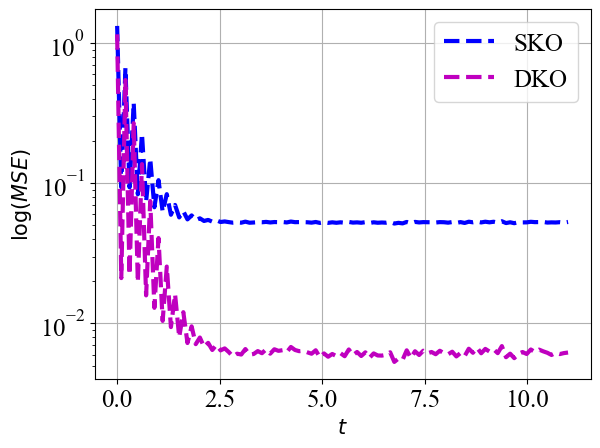

In [39]:
#plot the results

plt.semilogy(np.linspace(0, 11, N - 1), mean_SKO[1:], 'b', linestyle = "--", label = "SKO", linewidth = 3)
plt.semilogy(np.linspace(0, 11, N - 1), mean_DKO[1:], 'm', linestyle = "--", label = "DKO", linewidth = 3)
plt.legend()
plt.xlabel("$t$", fontsize = 15)
plt.grid()
plt.ylabel("$\log(MSE)$", fontsize = 15)
plt.savefig("state_dependent.png")

error at locations [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.] :
SKO:  [6.19292279e-48 9.76287983e-03 6.92844056e-03 6.90136005e-03
 7.00036416e-03 7.01646037e-03 7.04818993e-03 6.99428783e-03
 7.01522209e-03 7.02068207e-03 7.06536869e-03 7.07786526e-03]
DKO:  [6.19292279e-48 6.29248501e-04 2.46354102e-04 1.51848530e-04
 1.16620690e-04 1.15119113e-04 1.05273634e-04 1.17266446e-04
 1.28897914e-04 1.28004745e-04 1.08263688e-04 1.19127346e-04]


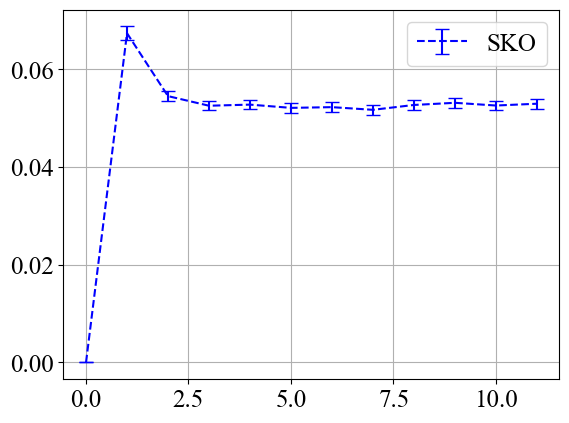

In [41]:
indices_error = np.arange(0, N, 10)
print("error at locations", indices_error*Dt, ":")
mask = np.zeros((N, ))
mask[indices_error] = var_SKO[indices_error]/np.sqrt(N_exp)
print("SKO: ", var_SKO[indices_error])
print("DKO: ", var_DKO[indices_error])

plt.errorbar(np.linspace(0, 11, N)[indices_error], mean_SKO[indices_error], yerr = mask[indices_error],
             linestyle = "--", color = "blue", capsize = 5, label = "SKO")
plt.legend()
plt.grid()

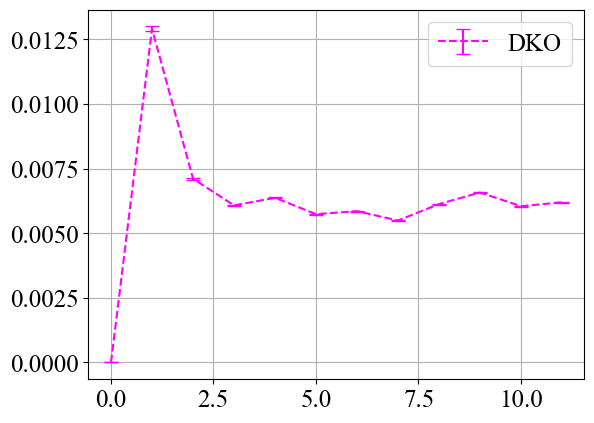

In [42]:
mask[indices_error] = var_DKO[indices_error]/np.sqrt(N_exp)
plt.errorbar(np.linspace(0, 11, N)[indices_error], mean_DKO[indices_error], yerr = mask[indices_error],
             linestyle = "--", color = "magenta", capsize = 5, label = "DKO")
plt.legend()
plt.grid()

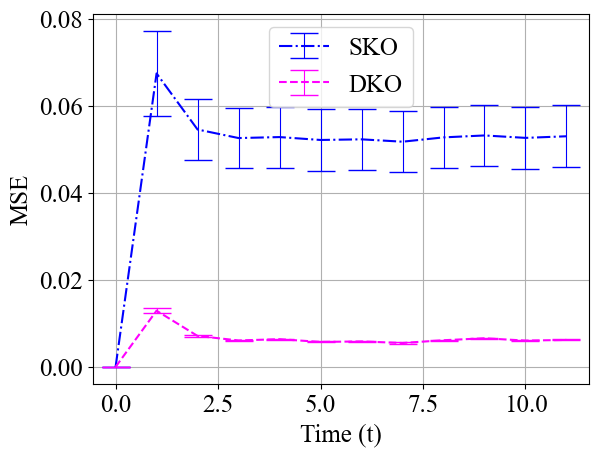

In [44]:
#plot the results
indices_error = np.arange(0, N, 10)


plt.figure()
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})

plt.errorbar(np.linspace(0, 11, N)[indices_error], mean_SKO[indices_error], yerr = var_SKO[indices_error],
             linestyle = "-.", color = "blue", capsize = 10, label = "SKO", elinewidth = 0.8 )
#plt.yscale("log")
mask[indices_error] = var_DKO[indices_error]/mean_DKO[indices_error]
plt.errorbar(np.linspace(0, 11, N)[indices_error], mean_DKO[indices_error], yerr = var_DKO[indices_error], 
             linestyle = "--", color = "magenta", capsize = 10, label = "DKO", elinewidth = 0.8)

plt.xlabel("Time (t)")
plt.ylabel("MSE")

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})

plt.legend()
plt.grid()
plt.savefig("state_dependent.png")